In [56]:
#Libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import datetime
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression

In [3]:
#See available styles for plot
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [31]:
#Plot Style
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))

In [32]:
#Inspect data. 
#Start of Task 1.
data = pd.read_csv("C:/Users/phyuo/OneDrive/Υπολογιστής/Python_coding/JPMorgan/Nat_Gas.csv")
data.head()

,Dates,Prices
0,10/31/20,10.1
1,11/30/20,10.3
2,12/31/20,11.0
3,1/31/21,10.9
4,2/28/21,10.9


In [33]:
#dtypes
data.dtypes

Dates      object
Prices    float64
dtype: object

In [34]:
#Change to datetime
data['Dates'] = pd.to_datetime(data.Dates, format='mixed',yearfirst=True)
data.head()

,Dates,Prices
0,2020-10-31,10.1
1,2020-11-30,10.3
2,2020-12-31,11.0
3,2021-01-31,10.9
4,2021-02-28,10.9


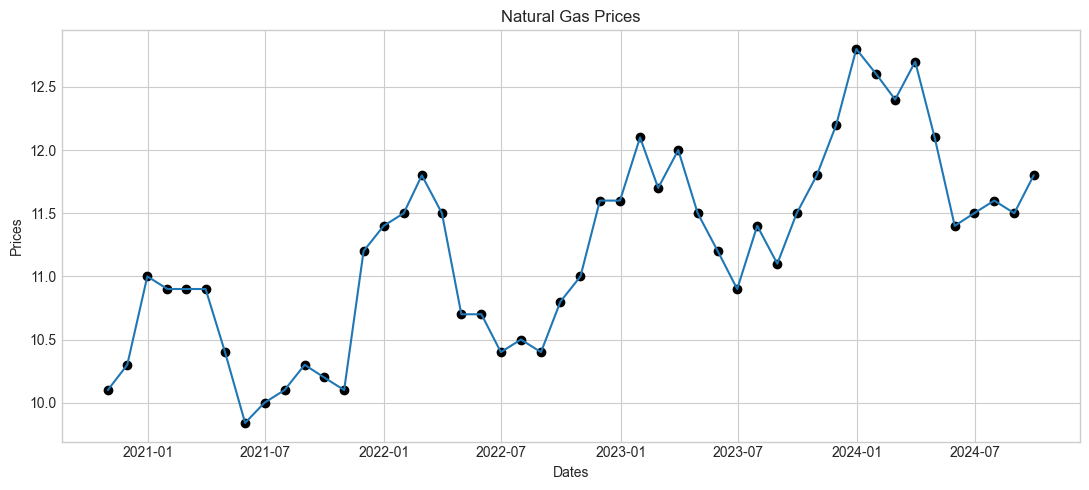

In [35]:
#Plot data
sns.lineplot(data=data, x='Dates', y='Prices')
plt.scatter(data['Dates'],data['Prices'],color='black',label='Prices')
plt.title('Natural Gas Prices')
plt.show()

In [36]:
#dummy time index 
data['time']=np.arange(len(data.index))

data.head()

,Dates,Prices,time
0,2020-10-31,10.1,0
1,2020-11-30,10.3,1
2,2020-12-31,11.0,2
3,2021-01-31,10.9,3
4,2021-02-28,10.9,4


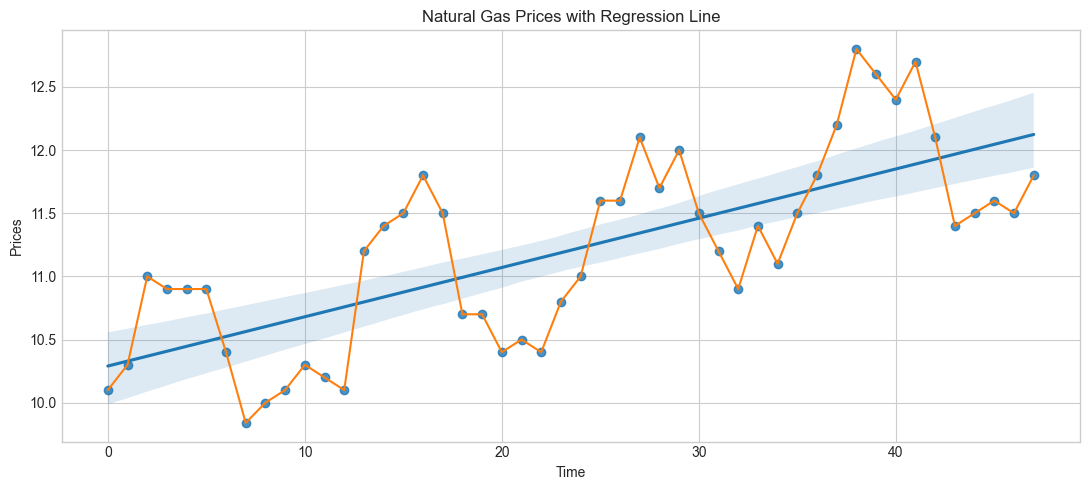

In [37]:
#Trend Plot of data against dummy time variable
sns.regplot(data=data, x='time', y='Prices')
plt.plot('time','Prices',data=data)
plt.xlabel('Time')
plt.ylabel('Prices')
plt.title('Natural Gas Prices with Regression Line')
plt.show()

In [38]:
#Create distinct feature for the year and the month, useful for the next ploting function
data['year'] = data['Dates'].dt.year
data['month'] = data['Dates'].dt.month
data.head()

,Dates,Prices,time,year,month
0,2020-10-31,10.1,0,2020,10
1,2020-11-30,10.3,1,2020,11
2,2020-12-31,11.0,2,2020,12
3,2021-01-31,10.9,3,2021,1
4,2021-02-28,10.9,4,2021,2


In [39]:
#Indexing by Dates
data = data.set_index(data['Dates'])
data = data.drop('Dates',axis=1)

In [40]:
#function for plotting Prices per month for each year
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique())
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        errorbar=('ci', False),
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(10, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


<Axes: title={'center': 'Seasonal Plot (year/month)'}, xlabel='month', ylabel='Prices'>

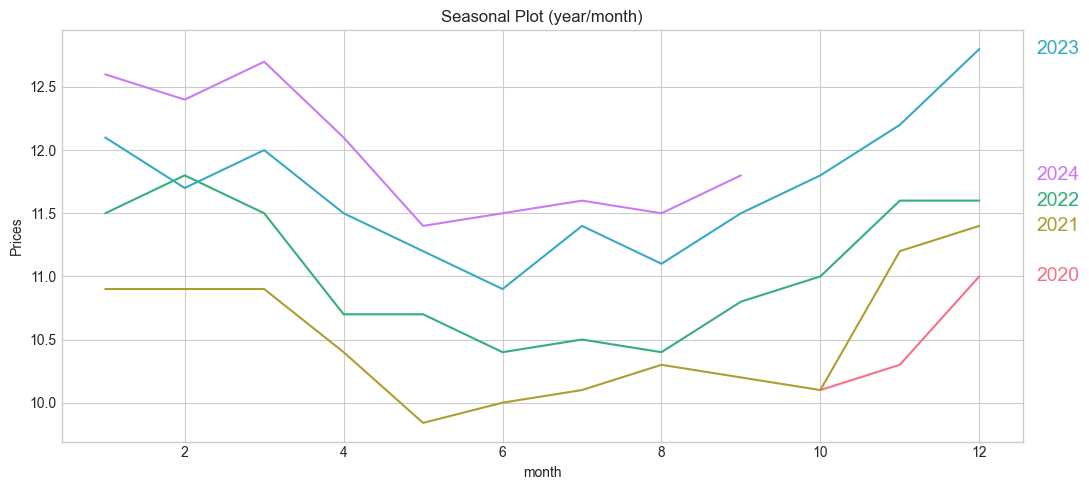

In [41]:
#Plot Prices per month for each year
seasonal_plot(data, data['Prices'], 'year', 'month')

In [42]:
#We will proceed by interpolating between months to estimate the daily prices of natural gas. We store this in a new dataframe called new_df.
new_df = pd.DataFrame()
new_df['dates']=pd.date_range(start='2020-10-31',end='2024-09-30')
new_df= new_df.set_index(new_df['dates'])
new_df = new_df.drop('dates',axis=1)
new_df = pd.merge(new_df,data,left_index=True,right_index=True,how='outer')
new_df = new_df.drop(['year','month','time'],axis=1)
for column in new_df.columns:
    new_df[f'{column}']=new_df[f'{column}'].interpolate(method='linear')
new_df

,Prices
2020-10-31,10.100000
2020-11-01,10.106667
2020-11-02,10.113333
2020-11-03,10.120000
2020-11-04,10.126667
...,...
2024-09-26,11.760000
2024-09-27,11.770000
2024-09-28,11.780000
2024-09-29,11.790000


In [43]:
#There is a clear upward trend in the Prices column of our data. It appears also that the price peaks at the very end or early in the year and reaches its lowest around July (Not very suprising).
#To model the price and predict it we will use a fourier series analysis as this fits the data better.
#We start with a periodogram to find the best number of fourier features to use.

def plot_periodogram(prices, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        prices,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

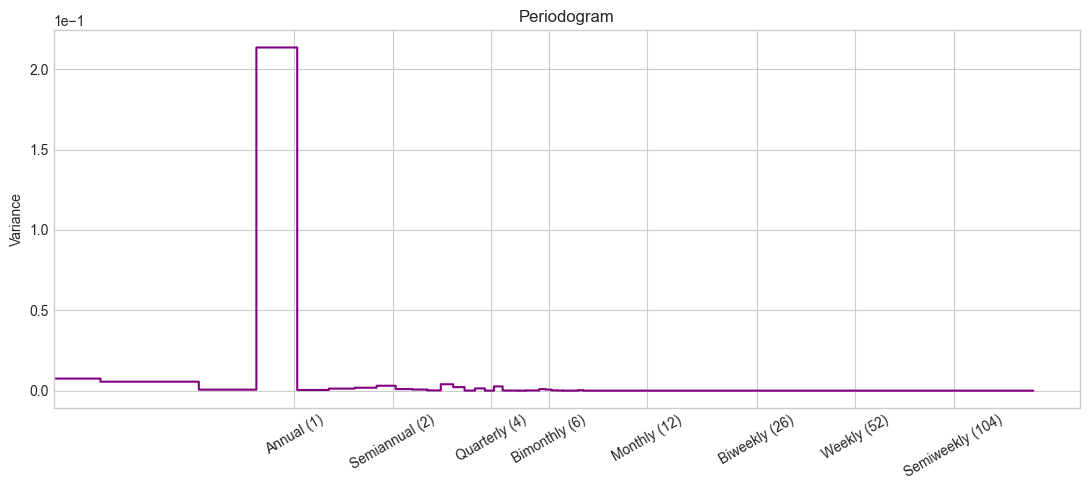

In [44]:
#Visualise periodogram
plot_periodogram(new_df.Prices)

In [45]:
#Create index for DeterministicProcess
index = pd.DatetimeIndex(new_df.index, freq='D')

In [47]:
#Judging from the above periodogram we are going to use one fourier pair for our modeling.
fourier = CalendarFourier(freq="YE", order=1)  # 1 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # daily seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()

In [48]:
#fit model
y=new_df['Prices']
regressor = LinearRegression(fit_intercept=False)
model = regressor.fit(X,y)
y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=396)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

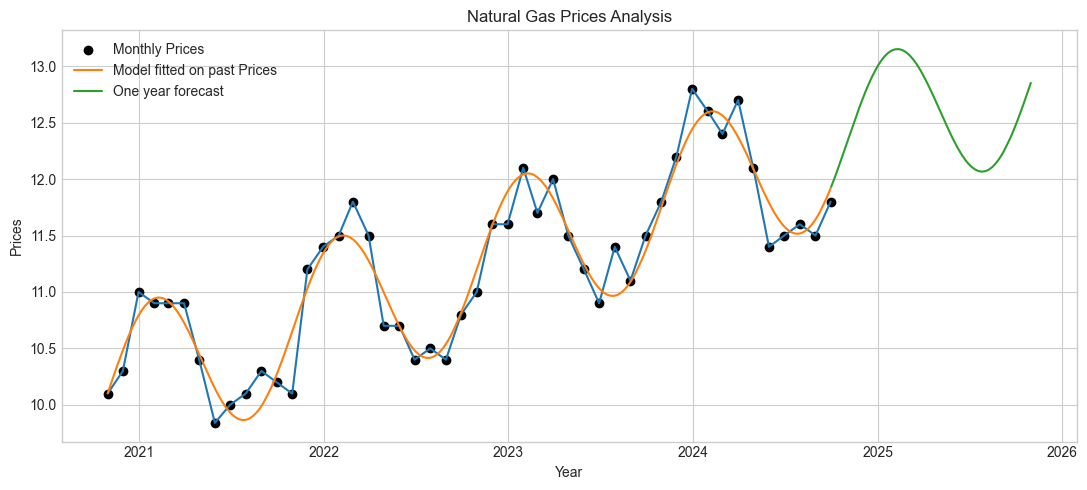

In [49]:
#Visualise forecast
plt.title('Natural Gas Prices Analysis')
plt.scatter(x=data.index,y=data['Prices'],color='black', label = 'Monthly Prices')
plt.plot(X.index,y)
plt.plot(X.index,y_pred,label='Model fitted on past Prices')
plt.plot(X_fore.index,y_fore, label='One year forecast')
plt.xlabel('Year')
plt.ylabel('Prices')
plt.legend()
plt.show()

In [50]:
#Merge X and X_fore into one dataframe called df
df = pd.concat([X,X_fore])

In [51]:
def estimating_past_and_future_prices(date):

    y_pred = model.predict(df[df.index == date])[0]

    return y_pred

In [52]:
#Estimate price for any date from 2020-10-31 to 2025-10-31 on a daily basis.
estimating_past_and_future_prices('2024-10-31')

12.30434529091044

In [53]:
#Calculating MAE for our model
mae = sum(abs(new_df.iloc[:,0]-y_pred))/(len(y_pred)-1)
mae

#End of Task 1.

0.12632449989218428

In [57]:
#Pricing the commodity and keeping track of all cash flows. (Task 2)
class Commodity:
    def __init__(self,model):
        self.model = model

    def est_price(self,date):
        y_pred = self.model.predict(df[df.index == date])[0]

        return y_pred 

    def est_prices_multiple_dates(self,dates):
        prices=[]
        for date in dates:
            y_pred = self.model.predict(df[df.index == date])[0]
            prices.append(y_pred)

        return prices


    def storage_time(self,injection_dates,withdrawal_dates):
        d1 = datetime.strptime(injection_dates[0], "%Y-%m-%d")
        d2 = datetime.strptime(withdrawal_dates[-1], "%Y-%m-%d")
        delta = d2 - d1
        time = round(delta.days/30,2)
        return time

    def list_transactions(self,injection_dates,vol_inj,withdrawal_dates,vol_with):
        transactions = {}
        for date,vol in zip(injection_dates,vol_inj):
            transactions[f'{date}']=('I',vol)
        for date,vol in zip(withdrawal_dates,vol_with):
            transactions[f'{date}']=('W',vol)
        transactions = sorted(transactions.items())
        return transactions

    def pricing(self,injection_dates,withdrawal_dates,rate,max_vol,storage_costs,vol_inj,vol_with):
        transactions = self.list_transactions(injection_dates,vol_inj,withdrawal_dates,vol_with)
        time = self.storage_time(injection_dates,withdrawal_dates)
        total_vol = 0 
        cash_flows = []
        for i in range(len(transactions)):
                date = transactions[i][0]
                if transactions[i][1][0] == 'I':
                    if transactions[i][1][1]<=max_vol:
                        cash_flow = -self.est_price(f'{date}')*transactions[i][1][1]-rate*transactions[i][1][1]
                        cash_flows.append(round(cash_flow,2))
                        total_vol += transactions[i][1][1]
                    else:
                        print('Storage is full')
                elif transactions[i][1][0] == 'W':
                    if transactions[i][1][1]<=total_vol:
                        cash_flow = self.est_price(f'{date}')*transactions[i][1][1]-rate*transactions[i][1][1]
                        cash_flows.append(round(cash_flow,2))
                        total_vol -= transactions[i][1][1]
                    else:
                        print('Not enough to withdraw')
        value = sum(cash_flows) - storage_costs*time
        return round(value,2), cash_flows

In [58]:
#Example
injection_dates=['2024-07-25','2024-08-25','2025-07-20']
vol_inj=[2000000,3000000,5000000]
withdrawal_dates=['2024-12-28','2025-01-28','2025-10-31']
vol_with = [3000000,2000000,5000000]
commodity = Commodity(model)
value,cash_flows = commodity.pricing(injection_dates,withdrawal_dates,0.01,5000000,100000,vol_inj,vol_with)
print(f'The value of the contract is {value} dollars, and the cash flows were {cash_flows}')

The value of the contract is 9499658.78 dollars, and the cash flows were [-23052530.83, -34840948.57, 38875496.39, 26253821.03, -60403480.36, 64210301.12]
